In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import collections

from sklearn.metrics import confusion_matrix, auc
from sklearn.ensemble import IsolationForest

# Data Loading

In [2]:
#Reading .csv
df = pd.read_csv('creditcard.csv', header = None)

#Separating feature dimensions from class labels
X_initial = df.iloc[1:, 1:30].values
y = df.iloc[1:, 30].values

X_initial = X_initial.astype('float')
y = y.astype('float')

/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


# Hyper Parameters

In [3]:
#Number of estimators for isolation forest
n_estimators = 100

#Max number of samples in the given dataset
max_samples = len(X_initial)

#Outlier fraction as contamination ratio
outlier_fraction = float(len(y[y == 1]))/float(len(y[y == 0]))

#Total random states for splitting
random_state = 5

#Number of bootstrapping runs
runs = 10

# Initializing Variables & Dictionaries

In [4]:
n = len(X_initial)

#Initializing dictionaries to store results for each run with the format {data[run_number]: [results]}
score = {}
y_true = {}
y_preds = {}
auprc = {}
auroc = {}

# Isolation Forest Algorithm & Generating PRC, ROC Curves


Run 1


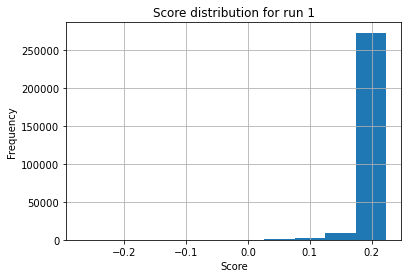

Plotting Precision-Recall and ROC Curves for run 1


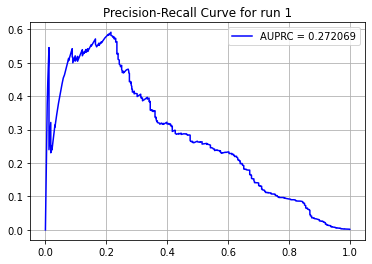

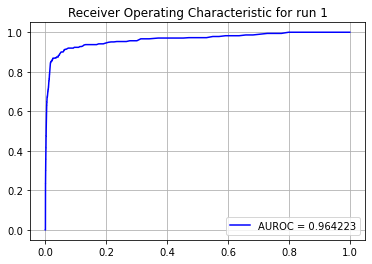


Run 2


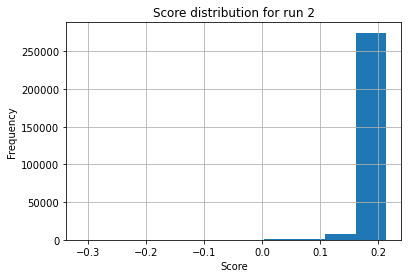

Plotting Precision-Recall and ROC Curves for run 2


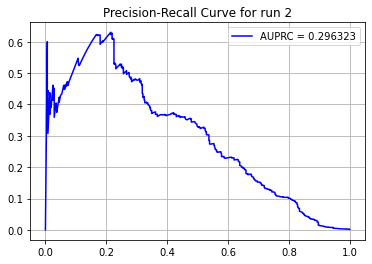

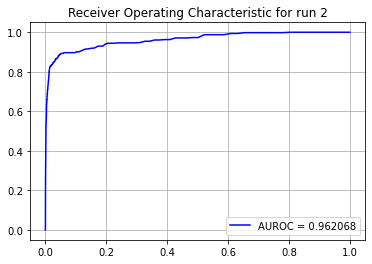


Run 3


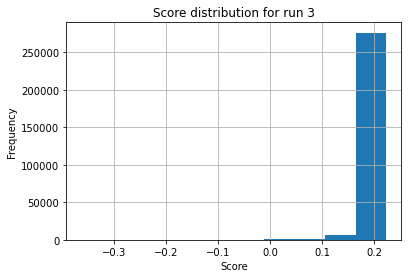

Plotting Precision-Recall and ROC Curves for run 3


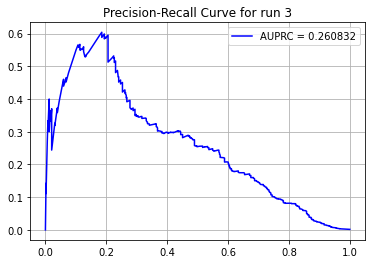

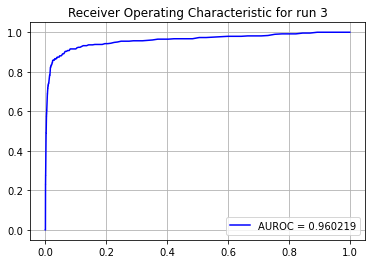


Run 4


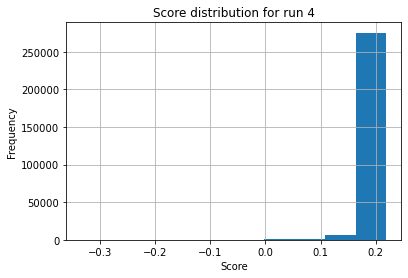

Plotting Precision-Recall and ROC Curves for run 4


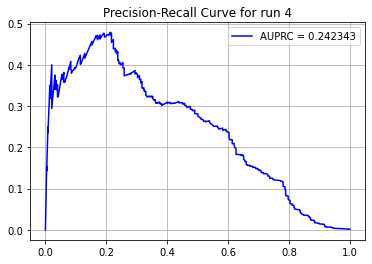

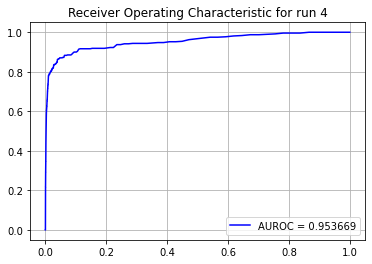


Run 5


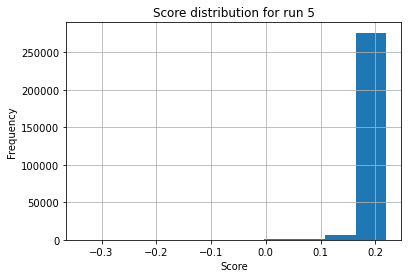

Plotting Precision-Recall and ROC Curves for run 5


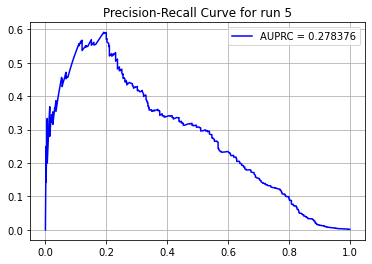

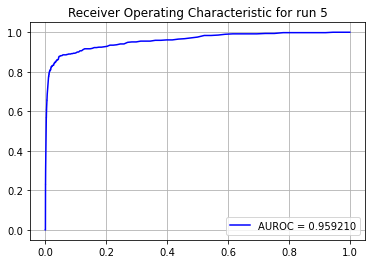


Run 6


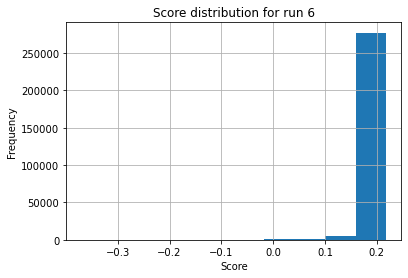

Plotting Precision-Recall and ROC Curves for run 6


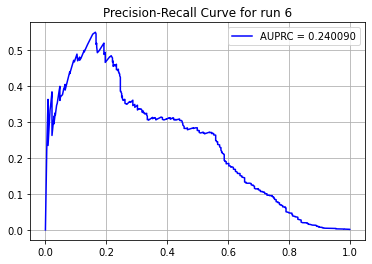

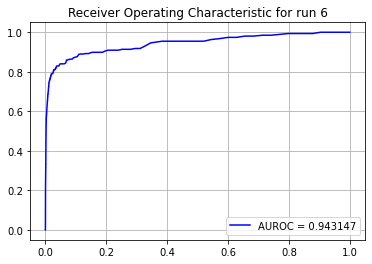


Run 7


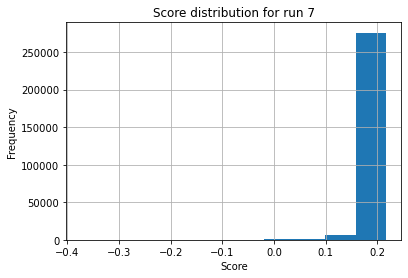

Plotting Precision-Recall and ROC Curves for run 7


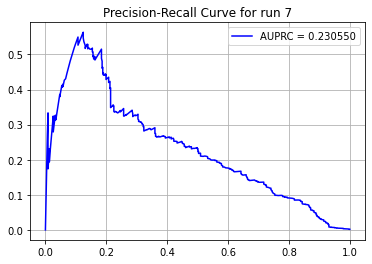

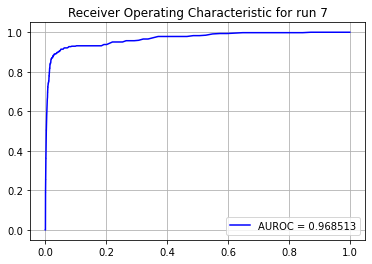


Run 8


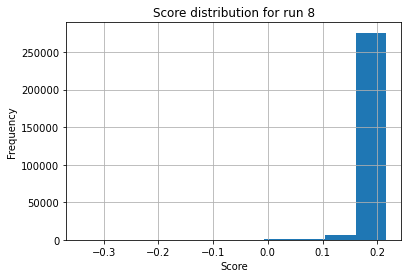

Plotting Precision-Recall and ROC Curves for run 8


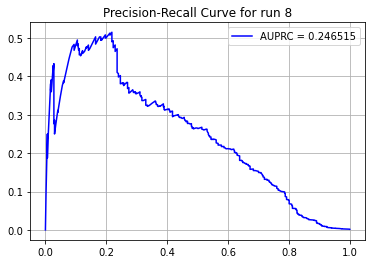

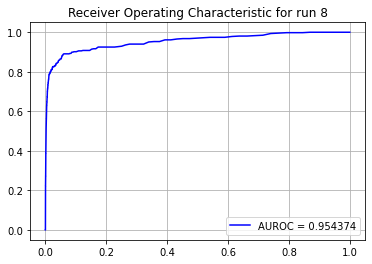


Run 9


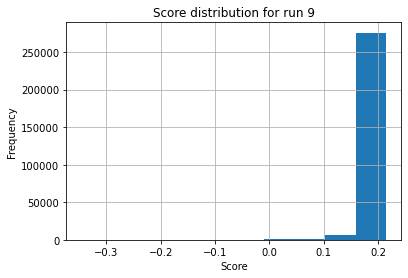

Plotting Precision-Recall and ROC Curves for run 9


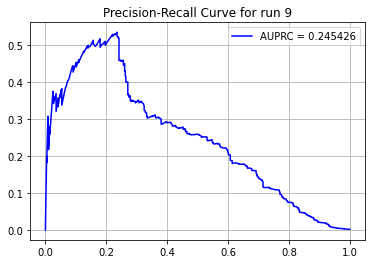

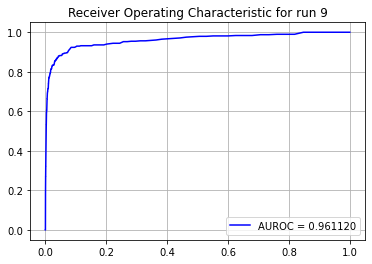


Run 10


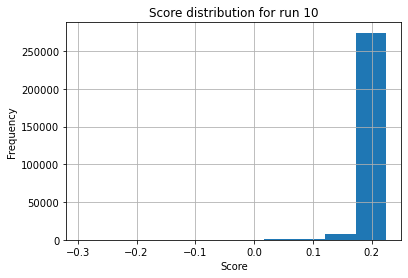

Plotting Precision-Recall and ROC Curves for run 10


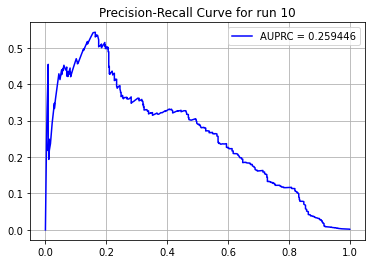

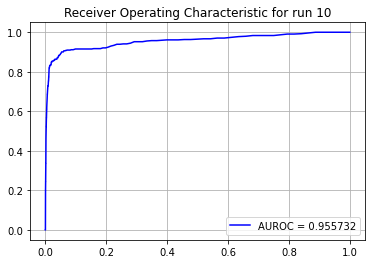

In [5]:
#Starting the loop for bootstrapping runs
for r in range(runs):
    print("")
    print("Run " + str(r+1))
    
    #Generating n random indexes with replacement
    bootstrap_index = np.random.choice(n, size = n, replace = True)
    
    #Selecting bootstrapped data (features & respective labels) using generated indexes
    X = X_initial[bootstrap_index]
    
    y_true[r+1] = y[bootstrap_index]
    
    #Initializing Sklearn's IsolationForest class with hyperparameters defined above
    isolation_forest_model = IsolationForest(n_estimators = n_estimators, 
                                             max_samples = max_samples,
                                             contamination = outlier_fraction,
                                             random_state = random_state)
    
    #Begin training process
    isolation_forest_model.fit(X)
    
    #Generating scores and predicted labels
    score[r+1] = isolation_forest_model.decision_function(X)
    y_preds[r+1] = isolation_forest_model.predict(X)
     
    #Re-formatting class labels based on the original set of class labels {0, 1}   
    y_preds[r+1][y_preds == 1] = 0
    y_preds[r+1][y_preds == -1] = 1

    #Plotting histogram of generated scores
    plt.figure()
    plt.title('Score distribution for run ' + str(r+1))
    plt.hist(score[r+1])
    plt.grid()
    plt.xlabel('Score')
    plt.ylabel('Frequency')
    plt.show()
    
    #Initializing a set of 1000 thresholds from the set (min(score), max(score))
    print("Plotting Precision-Recall and ROC Curves for run " + str(r+1))
    thresholds = np.linspace(score[r+1].min(), score[r+1].max(), num = 1001)[1:]

    #Initializing list of results for current run
    y_preds[r+1] = np.zeros(n) #predicted labels
    recall = np.zeros(len(thresholds)) #recall values
    precision = np.zeros(len(thresholds)) #precision values
    fpr = np.zeros(len(thresholds)) #false positive rate
    
    #Looping through each threshold
    for t in range(len(thresholds)):
        #print("Run " + str(r+1) + ", threshold " + str(t+1))
        
        #Set label = 1 if predicted score is below threshold
        y_preds[r+1][np.where(score[r+1] < thresholds[t])] = 1
        
        #Using Sklearn's confusion_matrix function to generate tn, fp, fn, tp values
        tn, fp, fn, tp = confusion_matrix(y_true[r+1], y_preds[r+1]).ravel()
        
        #Computing recall, precision and false positive rate
        recall[t] = tp/(tp + fn)
        precision[t] = tp/(tp + fp)
        fpr[t] = fp/(fp + tn)

    #Calculating area under the precision-recall curve
    i = np.array(range(1, len(recall)))
    re = recall[i] - recall[i-1]
    pre = precision[i] + precision[i-1]
    auprc[r+1] = np.sum(re * pre)/2
    
    #Plotting Precision-Recall curve
    plt.figure()
    plt.title('Precision-Recall Curve for run ' + str(r+1))
    plt.plot(recall, precision, 'b', label = 'AUPRC = %0.6f' % auprc[r+1])
    plt.grid()
    plt.legend(loc = 'upper right')
    plt.show()
    
    #Calculating area under the recall curve using Sklearn's auc function
    auroc[r+1] = auc(fpr, recall) 
    
    #Plotting ROC curve
    plt.figure()
    plt.title('Receiver Operating Characteristic for run ' + str(r+1))
    plt.plot(fpr, recall, 'b', label = 'AUROC = %0.6f' % auroc[r+1])
    plt.grid()
    plt.legend(loc = 'lower right')
    plt.show()

# Quantitative Analysis

In [7]:
print("----------------------")
print("AUPRC values per run:")
print(auprc)

print("Mean of AUPRC: " + str(np.mean(list(auprc.values()))))
print("Standard Deviation of AUPRC: " + str(np.std(list(auprc.values()))))
print("----------------------")

print("")
print("----------------------")
print("AUROC values per run:")
print(auroc)

print("Mean of AUROC: " + str(np.mean(list(auroc.values()))))
print("Standard Deviation of AUROC: " + str(np.std(list(auroc.values()))))
print("----------------------")

----------------------
AUPRC values per run:
{1: 0.2720688871546053, 2: 0.29632267180116834, 3: 0.2608318059812988, 4: 0.24234315177765353, 5: 0.2783764515245445, 6: 0.24008964090893908, 7: 0.2305502771814389, 8: 0.24651453077619792, 9: 0.24542612484200987, 10: 0.2594459653981652}
Mean of AUPRC: 0.25719695073460214
Standard Deviation of AUPRC: 0.019221979809392283
----------------------

----------------------
AUROC values per run:
{1: 0.964223222569988, 2: 0.9620681088378037, 3: 0.9602186947364874, 4: 0.953668794938763, 5: 0.9592103216494552, 6: 0.9431469982302944, 7: 0.9685128820805805, 8: 0.9543737298246107, 9: 0.9611197781315123, 10: 0.9557316418804834}
Mean of AUROC: 0.9582274172879979
Standard Deviation of AUROC: 0.006626222870524284
----------------------
